In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(dplyr)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Predicting Knowledge Level of Students

### Introduction

User modeling involves creating an imitation of the conceptual understanding of a user, which can be utilized to improve the customization and system interfaces to fit a user’s needs. Observations of users’ behavior can be used to train, then we will be able to form a model that is able to predict future actions. This serves as a cheaper and more efficient alternative to user testing, as it doesn't require human's to do the work. In this project, we will start with the foundation of user modelling, recognizing knowledge levels of peoples. The question we are trying to solve is if we can create an accurate and reliable classification model to predict peoples' knowledge level on a certain topic using attributes relating to the study that might affect the knowledge level.  

In this particular user model, the dataset we are using is obtained from Ph.D. Thesis, it is on the students' knowledge status about Electrical DC Machines. The dataset includes five attributes, STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), and PEG (The exam performance of user for goal objects). 

### Methods and Results

The dataset we used is the “User Knowledge” Dataset

The dataset is first downloaded. Since the dataset has already been split into training and testing sheets for us, we will read both sheets.

In [2]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", destfile = "dataset.xls")
set.seed(2022)
training_original <- read_excel("dataset.xls", sheet = 2)
testing_original <- read_excel("dataset.xls", sheet = 3)

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


However, we need the right ratio of observations of training to testing. Thus, the two sheets are then tidied and combined into one large dataset.

In [3]:
tidy_testing_original <- select(testing_original, STG:UNS)
tidy_training_original <- select(training_original, STG:UNS)
tidy_user_data_original <- bind_rows(tidy_testing_original, tidy_training_original)

We will take a brief look at the data distribution.

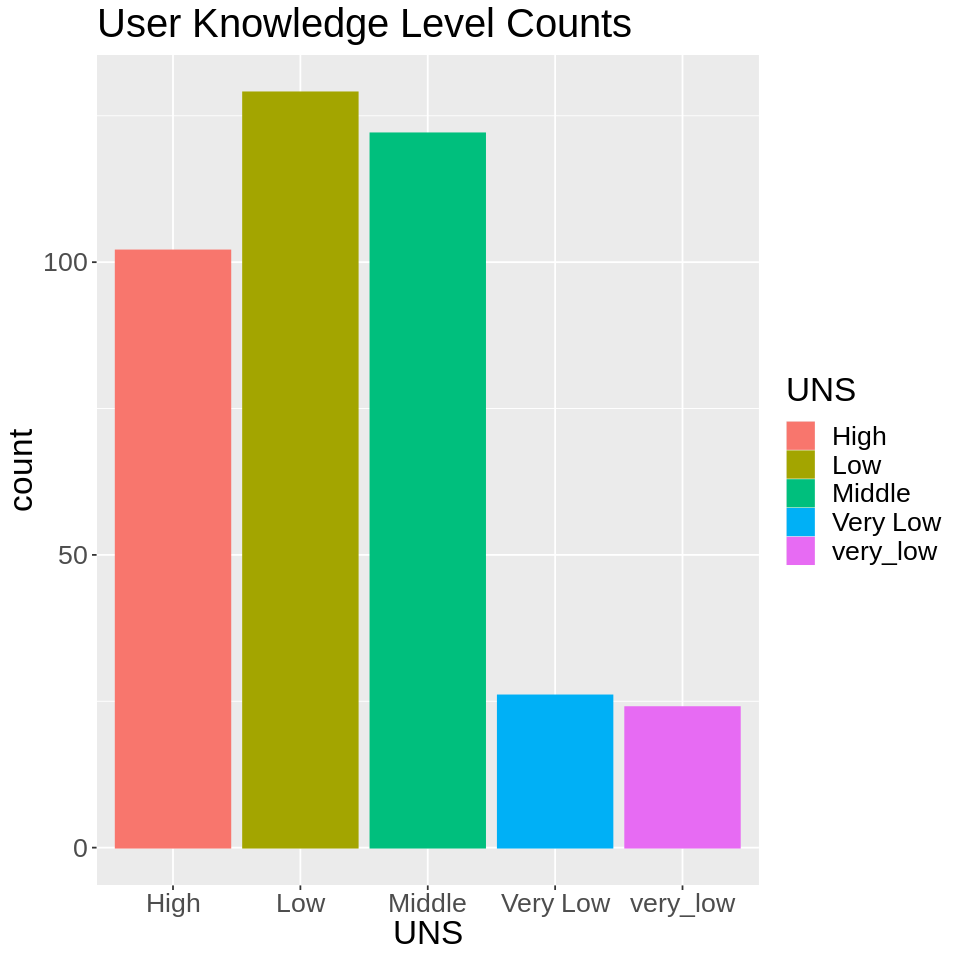

In [17]:
user_data_original_plot <- tidy_user_data_original |>
    ggplot(aes(x=UNS,colour=UNS,fill=UNS)) +
    geom_bar()+
    ggtitle("User Knowledge Level Counts")+
    theme(text=element_text(size=20))
user_data_original_plot

From the bar graph we see that there are two knowledge levels called "very low", and so we combine them. Also, we use the as_factor function to turn UNS(the user knowledge level) into a factor for the confusion matrix later on.

In [5]:
df1 <- tidy_user_data_original |>
    filter(UNS == "very_low") |>
    mutate(UNS = "Very Low")
df2 <- tidy_user_data_original |>
    filter(UNS != "very_low")
user_data <- bind_rows(df1, df2)

user_data <- mutate(user_data, UNS = as.factor(UNS))

We split the data into training and testing datasets oursevles, with a proprotion of 0.75 and evenly distributed UNS knowledge levels between the two datasets.

In [6]:
set.seed(2022)
user_split <- initial_split(user_data, prop=0.75, stata = UNS)
training <- training(user_split)
testing <- testing(user_split)
head(training)
head(testing)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.240,0.580,0.76,0.80,0.28,Middle
0.200,0.490,0.60,0.20,0.78,High
0.475,0.320,0.79,0.31,0.54,Middle
0.365,0.680,0.10,0.63,0.18,Low
0.120,0.245,0.75,0.31,0.59,Middle
0.290,0.300,0.56,0.25,0.67,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.150,0.020,0.34,0.40,0.01,Very Low
0.290,0.150,0.33,0.66,0.08,Very Low
0.251,0.265,0.57,0.60,0.09,Very Low
0.265,0.600,0.28,0.66,0.07,Very Low
0.590,0.180,0.31,0.55,0.09,Very Low
0.600,0.190,0.55,0.08,0.10,Very Low


Testing and Training Dataset 


A model specification and 5-fold cross validation object are made in preparation for cross validation.

In [7]:
set.seed(2022)

knn_spec_cross <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

user_vfold <- vfold_cv(training, v = 5, strata = UNS)

However, little is known about the meaning of the predictors and which predictors to use. Thus, forward selection is utilized to determine the best predictors to use in our classification model by testing out which combination of predictors will produce the highest accuracy with k=10 neighbours classification.

In [8]:
set.seed(2022)
names <- colnames(training |> select (-UNS))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        user_recipe_0 <- recipe(as.formula(model_string), 
                                data = training) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(user_recipe_0) |>
          add_model(knn_spec_cross) |>
          tune_grid(resamples = user_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
     names <- names[-jstar]}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8446934
2,UNS ~ PEG+LPR,0.9669836
3,UNS ~ PEG+LPR+SCG,0.9435843
4,UNS ~ PEG+LPR+SCG+STG,0.9107847
5,UNS ~ PEG+LPR+SCG+STG+STR,0.8441353


Accuracies of Different Combination of Predictors

The PEG and LPR predictors have the highest accuracies, and thus they will be used in the user knowledge recipe.

Cross Validation will then be used to determine the best k value (number of neighbours) for our classification model, with the results being graphed.

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

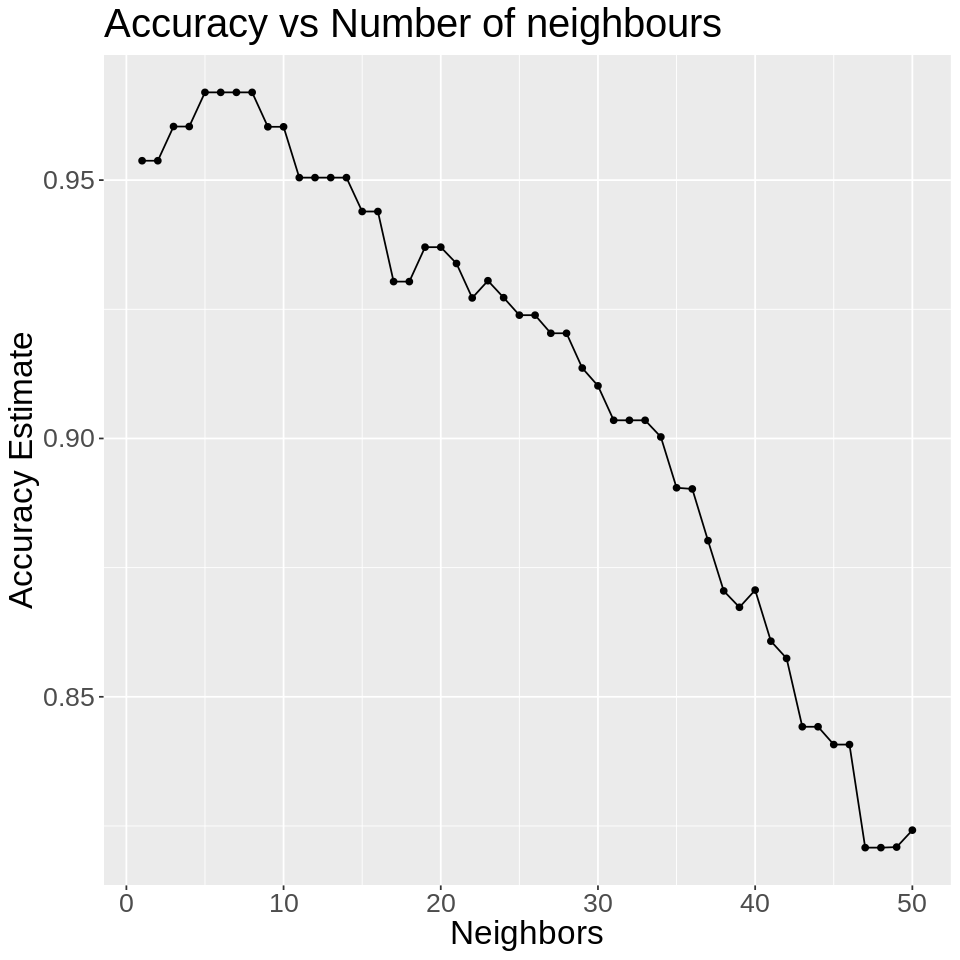

In [18]:
set.seed(2022)
user_knowledge_recipe <- recipe(UNS ~ PEG + LPR, data = training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
user_knowledge_recipe

gridvals <- tibble(neighbors = seq(1,50))


knn_results <- workflow() |>
    add_recipe(user_knowledge_recipe) |>
    add_model(knn_spec_cross) |>
    tune_grid(resamples = user_vfold, grid = gridvals) |>
    collect_metrics()

accuracies <- knn_results |> 
    filter(.metric == "accuracy")
options(repr.plot.height = 8, repr.plot.width = 8)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate",title = "Accuracy vs Number of neighbours") +
    theme(text=element_text(size=20))
accuracy_versus_k

From this graph, we can see that the smallest k value that produces the highest accuracy is k=5, which will be used in our classification model.

In [10]:
knn_spec_5 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")
user_knowledge_fit <- workflow() |>
    add_recipe(user_knowledge_recipe) |>
    add_model(knn_spec_5) |>
    fit(data = training)

Now that our classification model is made, it is then used to predict the UNS of the testing dataset. The accuracy and confusion matrix are then found.

In [11]:
user_knowledge_test_predictions <- predict(user_knowledge_fit, testing) |>
    bind_cols(testing)
user_knowledge_test_predictions |>
    metrics(truth = UNS, estimate = .pred_class)|>
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9405941


In [12]:
user_knowledge_mat <- user_knowledge_test_predictions |>
    conf_mat(truth = UNS, estimate = .pred_class)
user_knowledge_mat

          Truth
Prediction High Low Middle Very Low
  High       21   0      0        0
  Low         0  31      2        4
  Middle      0   0     31        0
  Very Low    0   0      0       12

In summary, the original excel file was read and tidied. We used forward selection to select the best combination of predictors, PEG and LPR, which we then used for cross validation to find the best k value, which was 5, for our model. The classification model was constructed, which let us predict the user knowledge level of people in the testing dataset with 94% accuracy.

### Discussion

A few issues must be noted. Forward selection was only done with k=10 neighbours to reduce the time that the code needed. If we tested all combinations of predictors, each with 10 values of k, the code would've taken hours to run. However, since it was discovered that the best value of k was 5 instead of 10, this may have affected the accuracy of the model for the worse. Another issue is that the best predictors the forward selection had picked were PEG and LPR, which represented the exam performances goal objects and related objects with goal objects, respectively. In other words, the two exam scores were used to create the model that predicted people's knowledge level. This is problematic because the UNS user knowledge level was likely determined from the exam performance of the user, which explains why the accuracy of the model was so high. However, the methods of which the data is collected is beyond the scope of this report.


Expected outcomes and significance: We expect to use STC, SCG, and PEG as predictors to predict the knowledge level of this user. When we can predict the knowledge level of a user, we can match the suitable learning objects and methods to the needs of the users/students to help them learn more effectively. This finding can allow for personalized education, allowing users to improve their academic performance and achieve their potential. This is much more efficient than one-size-fits-all systems. Future questions this project could lead to include predicting different study methods and strategies tailored to a user’s mannerisms.
 
